# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  


____

### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


#### **1.1:  What is the objective of this project in business terms?**

The objective of this project is to use various home features from Zillow’s housing database to build a model that accurately predicts the total assessed value of a property (taxvaluedollarcnt). This prediction helps improve the accuracy of the Zestimate—Zillow’s home valuation tool—which gives users a quick estimate of their home’s value based on comparable properties and current market conditions. From a business perspective, a more accurate Zestimate increases user trust, improves engagement on the platform, and helps buyers and sellers make informed decisions about whether a home is fairly priced.


#### **1.2:  How will your solution be used?**

Once the model is complete, it will be integrated into Zillow’s user-facing Zestimate tool, which provides homeowners with a free estimate of their property’s value based on similar homes and market trends. This offers a convenient alternative to paid appraisals and helps users track value appreciation over time. Buyers can also use the Zestimate to compare listing prices against market-based estimates, helping them judge whether a property is overpriced or a potential deal. 


#### **1.3:  How should success (or failure) be measured?**

Success for this exercise should be measured by how accurately the model predicts the actual assessed value of a property (taxvaluedollarcnt). This can be evaluated using regression metrics such as  or Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE), which quantify how close the model’s predictions are to the true values. A lower error indicates a more reliable Zestimate, which translates to better user trust and utility.

___

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

#### **Preliminary Data Analysis**

In [3]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [5]:
# Summarize the datasets using describe()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


#### **Preliminary Data Analysis: Null Feature Counts and Unique Counts**

In [6]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with 
# another with 'value' and 'unique' counts later on in this analysis. 
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"This dataset contain {df.shape[0]} rows")
    print(f"This dataset contain {df.shape[1]} columns")

    # Display the summary
    return summary

In [7]:
profile_dataset(df)

This dataset contain 77613 rows
This dataset contain 55 columns


,Feature,Type,Null Values,Null %,Count (Non-Null),Unique Values
0,buildingclasstypeid,Numeric,77598,99.98,15,2
1,finishedsquarefeet13,Numeric,77571,99.95,42,13
2,storytypeid,Numeric,77563,99.94,50,1
3,basementsqft,Numeric,77563,99.94,50,43
4,yardbuildingsqft26,Numeric,77543,99.91,70,59
5,fireplaceflag,Categorical,77441,99.78,172,1
6,architecturalstyletypeid,Numeric,77406,99.73,207,5
7,typeconstructiontypeid,Numeric,77390,99.71,223,4
8,finishedsquarefeet6,Numeric,77227,99.50,386,350
9,pooltypeid10,Numeric,77148,99.40,465,1


#### **Duplicate Analysis**

In [8]:
number_of_duplicates = df['parcelid'].duplicated().sum()

# show duplicated if any:
if  number_of_duplicates > 0:
    print(f"Number of duplicated Rows: {number_of_duplicates:,d}")    
else:
    print("No duplicates found.")
df_duplicates = df[df['parcelid'].duplicated()]

df_duplicates.head()

Number of duplicated Rows: 199


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
117,11393337,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,1940.0,NaN,NaN,2016.0,Y,14.0,6.037235e+13,43439.0
625,14634203,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1974.0,1.0,NaN,2016.0,NaN,NaN,6.059001e+13,289445.0
1018,11721753,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1923.0,NaN,NaN,2016.0,NaN,NaN,6.037220e+13,205123.0
1248,11289917,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,Y,15.0,6.037901e+13,136104.0
1734,11637029,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,NaN,...,NaN,NaN,1980.0,NaN,NaN,2016.0,Y,13.0,6.037701e+13,810694.0


In [9]:
# df_unique = df.drop_duplicates(subset=['parcelid'], keep='last')
# df_unique.head()

### **2.A Discussion:** Answer the following questions.

#### **2.A.1:  Which features are categorical?**

The following features are categorical: 
- hashottuborspa
- propertycountylandusecode
- propertyzoningdesc
- fireplaceflag
- taxdelinquencyflag

In addition, the dataset includes several enumerated fields that, while technically numeric, represent categorical data. While there were many of these fields, the following had variable mappings that were able to be paired from Zillow's Kaggle enumeration key. 

- HeatingOrSystemTypeID
- PropertyLandUseTypeID
- StoryTypeID
- AirConditioningTypeID
- ArchitecturalStyleTypeID
- TypeConstructionTypeID
- BuildingClassTypeID



#### **2.A.2:  Are there any features which appear at first glance to be *useless* for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.**

In our analysis, we found that many columns containing 'id' in their names were flagged for review, as only a few had corresponding enumeration keys we were able to locate. Our general approach was that if an enumeration key was available and could be used to convert the values into meaningful categorical variables, we would do so—but each case needed to be assessed individually.

Additionally, several fields appeared to contain redundant or overlapping information. For example, finishedsquarefeet12 and finishedsquarefeet13 both relate to the size and perimeter of a living area within a home. While these might seem useful at first glance, they appear redundant when considering other fields such as calculatedfinishedsquarefeet, which offers a more comprehensive measure of total living space. Since area and perimeter are mathematically related, keeping both could introduce multicollinearity into the model. Furthermore, these fields had differing levels of missing data. For these reasons, they were flagged for review to assess whether consolidation was appropriate. Comments were added to the feature review table indicating potential consolidations, and final decisions on which features to retain were made during Part 3 of the project.


#### **2.A.3: Are there any features which appear to be *useless* because of the percentage of missing values?  If so, give an example.**

The following features were flagged for further review in addition to those with ‘id’-related variables due to high levels of missing data. Generally, any variable with more than 60% missing values was marked for additional consideration.

After this further review, we will determine whether each field is suitable for continued analysis. For instance, some fields—such as fireplaceflag—are formatted in a boolean manner, where a “yes” is entered or the field is left null. This structure may actually be useful for analysis after some data processing to convert 'yes' and null values into 1's and 0's etc. Additionally, fields need to be reviewed to see if they can be consolidated in order to reach a useability threshold. 

However, any final decision will need to take the following factors into account:

- Whether the field is useful and sufficiently complete for analysis
- Whether the field can be consolidated with other variables
 

| Feature                      | Null Values | Null % | Type         |
|-----------------------------|-------------|--------|--------------|
| buildingclasstypeid         | 77,598      | 99.98% | Numeric      |
| finishedsquarefeet13        | 77,571      | 99.95% | Numeric      |
| basementsqft                | 77,563      | 99.94% | Numeric      |
| storytypeid                 | 77,563      | 99.94% | Numeric      |
| yardbuildingsqft26          | 77,543      | 99.91% | Numeric      |
| fireplaceflag               | 77,441      | 99.78% | Categorical  |
| architecturalstyletypeid    | 77,406      | 99.73% | Numeric      |
| typeconstructiontypeid      | 77,390      | 99.71% | Numeric      |
| finishedsquarefeet6         | 77,227      | 99.50% | Numeric      |
| pooltypeid10                | 77,148      | 99.40% | Numeric      |
| decktypeid                  | 76,999      | 99.21% | Numeric      |
| poolsizesum                 | 76,744      | 98.88% | Numeric      |
| pooltypeid2                 | 76,539      | 98.62% | Numeric      |
| hashottuborspa              | 76,074      | 98.02% | Categorical  |
| yardbuildingsqft17          | 75,220      | 96.92% | Numeric      |
| taxdelinquencyflag          | 74,713      | 96.26% | Categorical  |
| taxdelinquencyyear          | 74,713      | 96.26% | Numeric      |
| finishedsquarefeet15        | 74,586      | 96.10% | Numeric      |
| finishedsquarefeet50        | 71,576      | 92.22% | Numeric      |
| finishedfloor1squarefeet    | 71,576      | 92.22% | Numeric      |
| fireplacecnt                | 69,324      | 89.32% | Numeric      |
| threequarterbathnbr         | 67,507      | 86.98% | Numeric      |
| pooltypeid7                 | 62,534      | 80.57% | Numeric      |
| poolcnt                     | 61,439      | 79.16% | Numeric      |
| numberofstories             | 60,014      | 77.32% | Numeric      |
| airconditioningtypeid       | 52,606      | 67.78% | Numeric      |
| garagecarcnt                | 52,093      | 67.12% | Numeric      |
| garagetotalsqft             | 52,093      | 67.12% | Numeric      |
| regionidneighborhood        | 46,639      | 60.09% | Numeric      |


**2.A.4: Are there any features which appear to be *useless* because of the number of unique values?  If so, give an example.**

Yes, there were several features that appeared to be potentially useless due to their number of unique values. This issue was noticeable at both ends of the uniqueness spectrum—some features had an extremely high number of unique values, while others had very few.

For example, parcelid had over 77,000 unique values and appeared to function primarily as a unique identifier for individual parcels of land. While this might seem immediately discardable, we chose to flag it for further review rather than remove it outright. Our intention was to conduct a comprehensive variable review to determine whether certain fields could be transformed or consolidated in a way that would make them useful for modeling.

Similarly to parcelid, latitude and longitude contained a high number of unique values. While these could potentially be used to geographically locate a property, other features such as zipcode or neighborhood are likely to provide more interpretable and relevant groupings for modeling housing prices. These columns were also flagged for review.

At the low end of the uniqueness spectrum, some features had only one or two unique values. For example, storytypeid contained only a single value across the entire dataset. Fields like this were also flagged for review, as having only one enumerated value can either indicate incomplete or inconsistent data entry, or that the field genuinely lacks variation. In both cases, such features are unlikely to contribute meaningful information to predictive models.

#### **Overall Feature Pre-Analysis and Flagging**

Feature variables were considered potentially useless if they met one or more of the following criteria:

- A high percentage of null values
- Uninterpretable or irrelevant for the scope of this analysis
- Categorical fields (e.g., description columns) with over 1,000 unique text values, making them difficult to encode meaningfully
- Extremely low variation, such as fields with only one unique value — for example, assessmentyear contains only a single value because the data was extracted in a single year


As a summary -- feature columns were flagged with the following symbols after pre-analysis: 

- ✅            Green Check - Low null counts / mangagable unique values
- ⚠️ / ✅       Flagged for Review - had high null or unique value counts but might be able to be consolidated / used anyways 
- ⚠️            Issue Flagged for for review within the broader team 
- ❌            Issue Flagged for review, likely to be dropped due to severity of issues. 




| Keep or Consolidate | Feature                   | Description                                                                 | Reason for Dropping / Description                                                                                          | Enumeration Key Exists |
|---------------------|---------------------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|------------------------|
| ⚠️                  | airconditioningtypeid     | Type of cooling system present in the home (if any)                        | 67 percent null -- 'yes' and 'none' in enums suggest inconsistent filling                                                 | Yes                    |
| ❌                  | architecturalstyletypeid  | Architectural style of the home (ranch, colonial, etc.)                    | Very few rows populated (208)                                                                                              | Yes                    |
| ⚠️                  | basementsqft              | Finished living area below ground level                                    | 99.94% null                                                                                                                |                        |
| ✅                  | bathroomcnt               | Number of bathrooms including fractional                                   |                                                                                                                             |                        |
| ✅                  | bedroomcnt                | Number of bedrooms                                                         |                                                                                                                             |                        |
| ✅                  | buildingqualitytypeid     | Overall assessment of building condition                                   |                                                                                                                             |                        |
| ❌                  | buildingclasstypeid       | Building framing type                                                      | 2 unique values, very few rows populated                                                                                   | Yes                    |
| ✅                  | calculatedbathnbr         | Bathrooms including fractional bathroom                                    |                                                                                                                             |                        |
| ⚠️                  | decktypeid                | Type of deck (if any)                                                      | 99.21% null                                                                                                                 |                        |
| ⚠️ / ✅             | threequarterbathnbr       | Number of 3/4 bathrooms                                                    | 86.98% null but seems reasonable                                                                                           |                        |
| ⚠️                  | finishedfloor1squarefeet  | Finished area on the first floor                                           | 92.22% null -- looks redundant with finishedsquarefeet50                                                                   |                        |
| ✅                  | calculatedfinishedsquarefeet | Calculated total finished living area                                  |                                                                                                                             |                        |
| ⚠️                  | finishedsquarefeet6       | Base unfinished and finished area                                          | 99.5% null -- can be consolidated with finishedsquarefeet12                                                                |                        |
| ✅                  | finishedsquarefeet12      | Finished living area                                                       | Only 4% null                                                                                                                |                        |
| ⚠️                  | finishedsquarefeet13      | Perimeter living area                                                      | 99.95% null -- can be consolidated with finishedsquarefeet12                                                               |                        |
| ⚠️                  | finishedsquarefeet15      | Total area                                                                 | 96.1% null -- can be consolidated with finishedsquarefeet12                                                                |                        |
| ⚠️                  | finishedsquarefeet50      | Entry floor living area                                                    | 92.22% null -- looks redundant with finishedsquarefeet12                                                                   |                        |
| ✅                  | fips                      | Federal Information Processing Standard code                               |                                                                                                                             |                        |
| ⚠️ / ✅             | fireplacecnt              | Number of fireplaces                                                       | 89.32% null — can be consolidated with fireplaceflag                                                                        |                        |
| ⚠️                  | fireplaceflag             | Is a fireplace present                                                     | 92.22% null -- redundant with fireplacecnt                                                                                 |                        |
| ✅                  | fullbathcnt               | Number of full bathrooms                                                   |                                                                                                                             |                        |
| ⚠️ / ✅             | garagecarcnt              | Total number of garages                                                    | 67% null                                                                                                                    |                        |
| ⚠️ / ✅             | garagetotalsqft           | Total garage square feet                                                   | Could be consolidated with garagecarcnt                                                                                     |                        |
| ⚠️ / ✅             | hashottuborspa            | Hot tub or spa present                                                     | 92.22% null — redundant with pooltypeid2                                                                                    |                        |
| ✅                  | heatingorsystemtypeid     | Type of home heating system                                                |                                                                                                                             | Yes                    |
| ❌                  | latitude                  | Latitude of parcel center ×10^6                                            | Out of scope                                                                                                                |                        |
| ❌                  | longitude                 | Longitude of parcel center ×10^6                                           | Out of scope                                                                                                                |                        |
| ✅                  | lotsizesquarefeet         | Area of lot in square feet                                                 |                                                                                                                             |                        |
| ⚠️ / ✅             | numberofstories           | Number of stories or levels                                                | 77.32% null                                                                                                                 |                        |
| ❌                  | parcelid                  | Unique parcel identifier                                                   |                                                                                                                             |                        |
| ⚠️ / ✅             | poolcnt                   | Number of pools                                                            | 77.32% null — other pool fields should be consolidated with this                                                            |                        |
| ⚠️                  | poolsizesum               | Total pool square footage                                                  | 92.22% null — redundant with finishedsquarefeet50                                                                           |                        |
| ⚠️                  | pooltypeid10              | Spa or Hot Tub                                                             | 99.4% null — consolidate with hashottuborspa                                                                                |                        |
| ⚠️                  | pooltypeid2               | Pool with Spa/Hot Tub                                                      | 99.62% null — consolidate with poolcnt and hashottuborspa                                                                   |                        |
| ⚠️                  | pooltypeid7               | Pool without hot tub                                                       | Consolidate with poolcnt                                                                                                    |                        |
| ❌                  | propertycountylandusecode | County land use / zoning code                                              | 75 unknown IDs                                                                                                              |                        |
| ✅                  | propertylandusetypeid     | Zoning category                                                            |                                                                                                                             | Yes                    |
| ❌                  | propertyzoningdesc        | Description of allowed land uses                                           | 92.22% null — redundant                                                                                                     |                        |
| ❌                  | rawcensustractandblock    | Raw census tract and block                                                 | 39k unique, unprocessed IDs                                                                                                 |                        |
| ❌                  | censustractandblock       | Census tract and block ID                                                  | 92.22% null — redundant                                                                                                     |                        |
| ✅                  | regionidcounty            | County where the property is located                                       |                                                                                                                             |                        |
| ❌                  | regionidcity              | City of the property                                                       | 175 unique values — not in scope for this milestone                                                                         |                        |
| ❌                  | regionidzip               | ZIP code of property                                                       | 389 unique values — not in scope for this milestone                                                                         |                        |
| ❌                  | regionidneighborhood      | Neighborhood of property                                                   | 480 unique values                                                                                                           |                        |
| ✅                  | roomcnt                   | Total rooms in the residence                                               |                                                                                                                             |                        |
| ❌                  | storytypeid               | Type of floors in multi-story home                                         | Only 1 unique value in 350 rows                                                                                              | Yes                    |
| ⚠️                  | typeconstructiontypeid    | Type of construction material                                              | 99.71% null                                                                                                                 | Yes                    |
| ✅                  | unitcnt                   | Number of units in the structure                                           |                                                                                                                             |                        |
| ⚠️                  | yardbuildingsqft17        | Patio in yard                                                              | 96.92% null — 540 unique values                                                                                             |                        |
| ⚠️ / ✅             | yardbuildingsqft26        | Storage shed/building in yard                                              | 99.91% null — seems reasonable; could be renamed "hasshed"                                                                  |                        |
| ❌                  | yearbuilt                 | Year residence was built                                                   | Already used to compute propertyage and yearbuilt_decade                                                                   |                        |
| ✅                  | taxvaluedollarcnt         | Total tax-assessed value                                                   |                                                                                                                             |                        |
| ❌                  | assessmentyear            | Year of property tax assessment                                            | Only one value (2016)                                                                                                       |                        |
| ⚠️ / ✅             | taxdelinquencyflag        | Whether taxes were delinquent                                              |                                                                                                                             |                        |
| ⚠️                  | taxdelinquencyyear        | Year taxes were delinquent                                                 | Same null count as taxdelinquencyflag — could consolidate to boolean                                                        |                        |

___

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

**First, let's combine the enumerated fields (that can be mapped) with the other categorical data.** 

In [10]:
# =======================================================
# Split df into Numeric and Categorical Datasets, so that 
# visualizations can be catered accordingly. 
# =======================================================

# Numeric Columns
numeric_cols = df.select_dtypes(include='number').columns
filtered_cols = [col for col in numeric_cols if 'id' not in col.lower()] # Filter OUT 'id' columns
df_numeric = df[filtered_cols]


# Categorical columns
df_categorical_cols = df.select_dtypes(exclude=['number']).columns
cat_id_cols = [col for col in df.columns if 'id' in col.lower()] #.lower() to avoid any capitalization issues
combined_cat_cols = list(df_categorical_cols) + cat_id_cols
df_categorical = df[combined_cat_cols]

#### **Numeric Data Pre-Analysis - Histograms**

<Figure size 1600x4000 with 0 Axes>

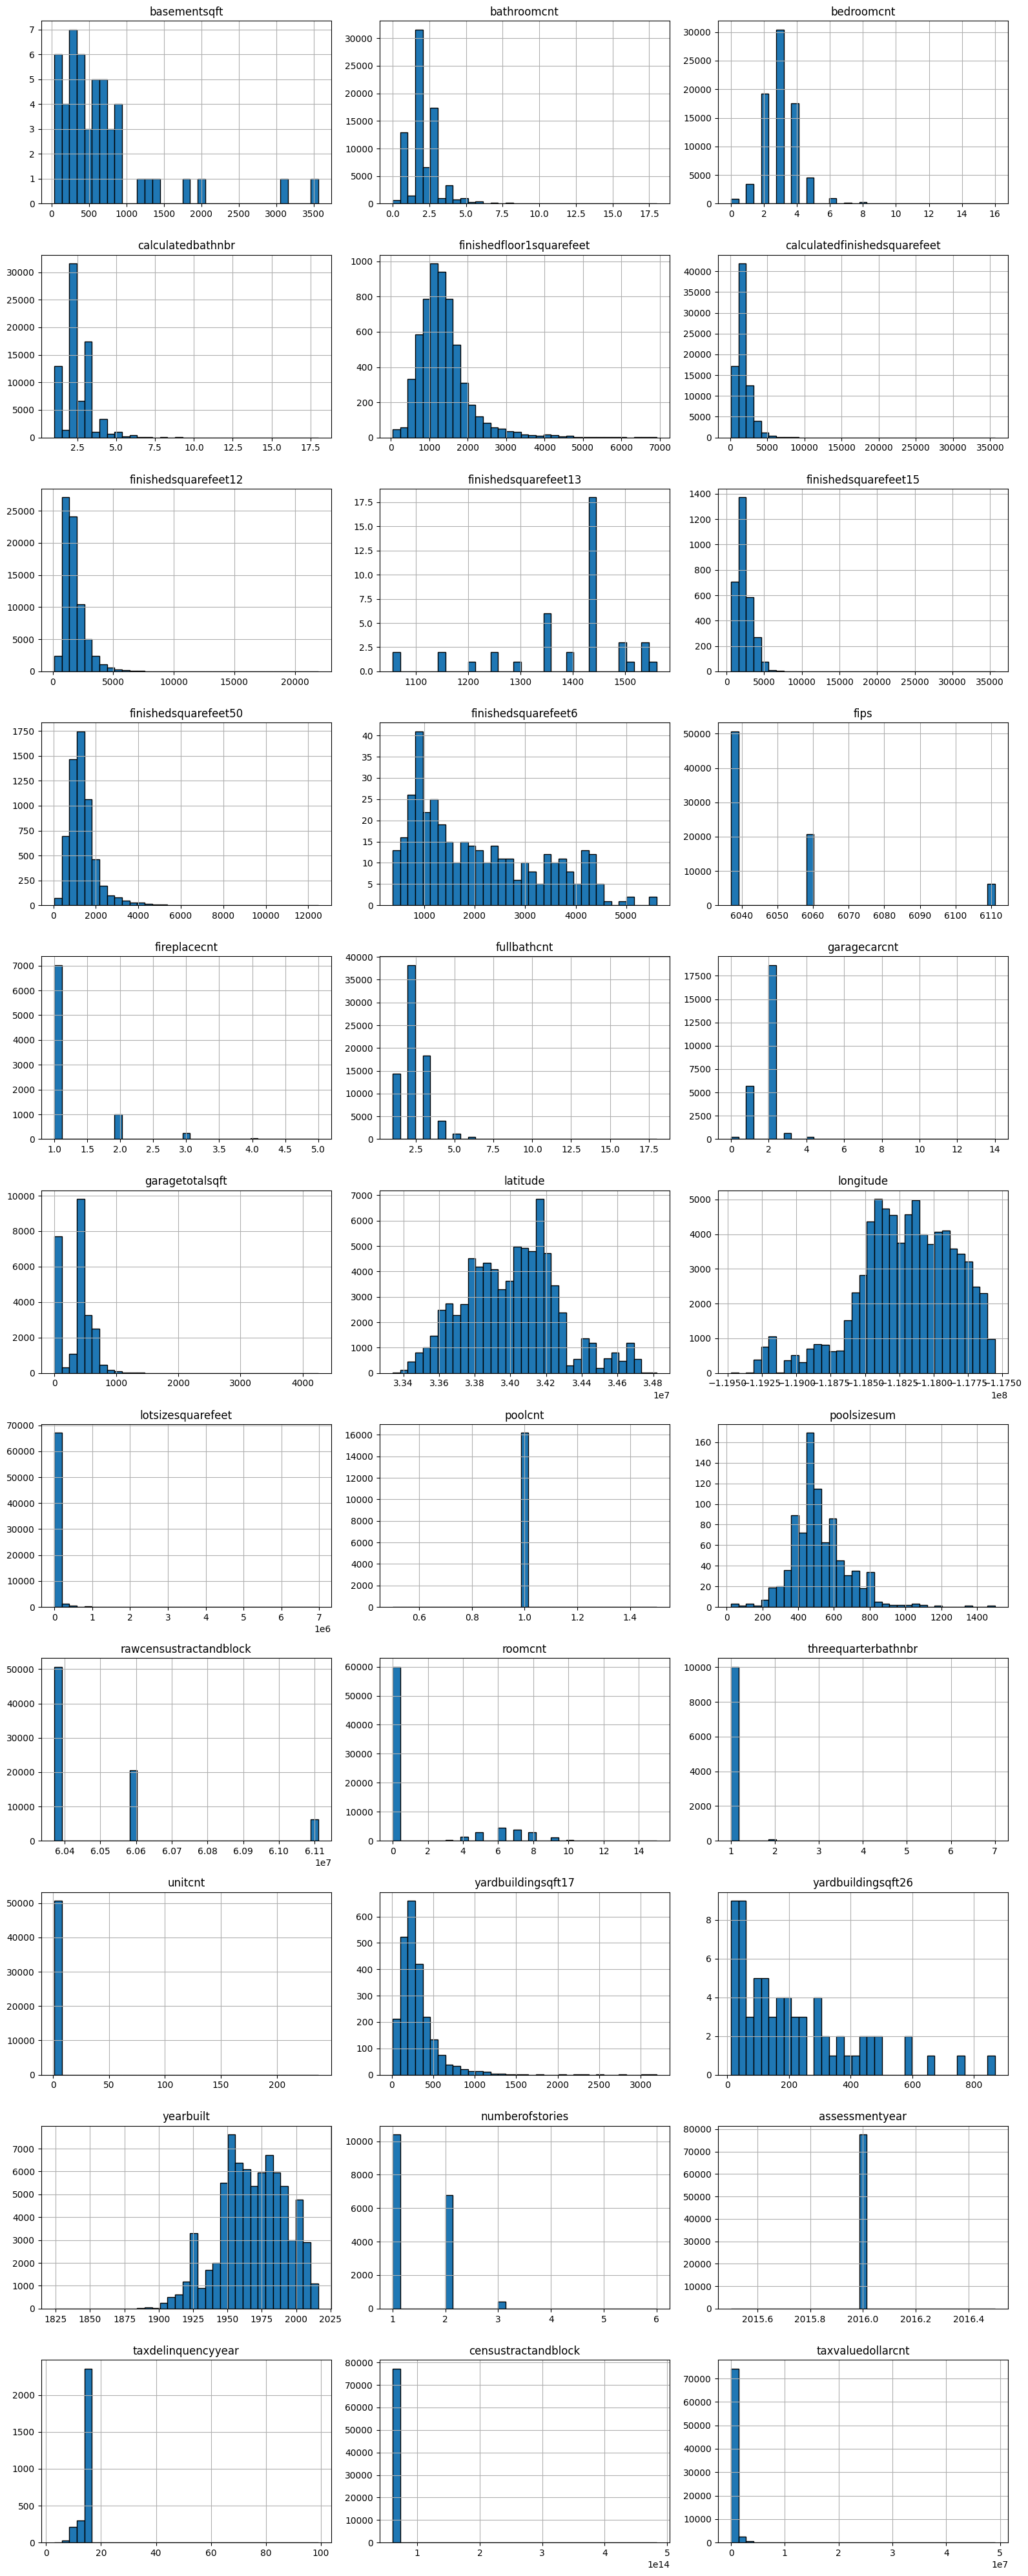

In [11]:
# =======================================================
# Generate Histograms for each of the numerical features 
# in the dataset. (Target variable was included as well)
# =======================================================

plt.figure(figsize=(16,40))
df_numeric.hist(bins=35, figsize=(16, 40), layout=(-1,3), edgecolor='black')
plt.tight_layout()

#### **Numeric Data Pre-Analysis: BoxPlots**

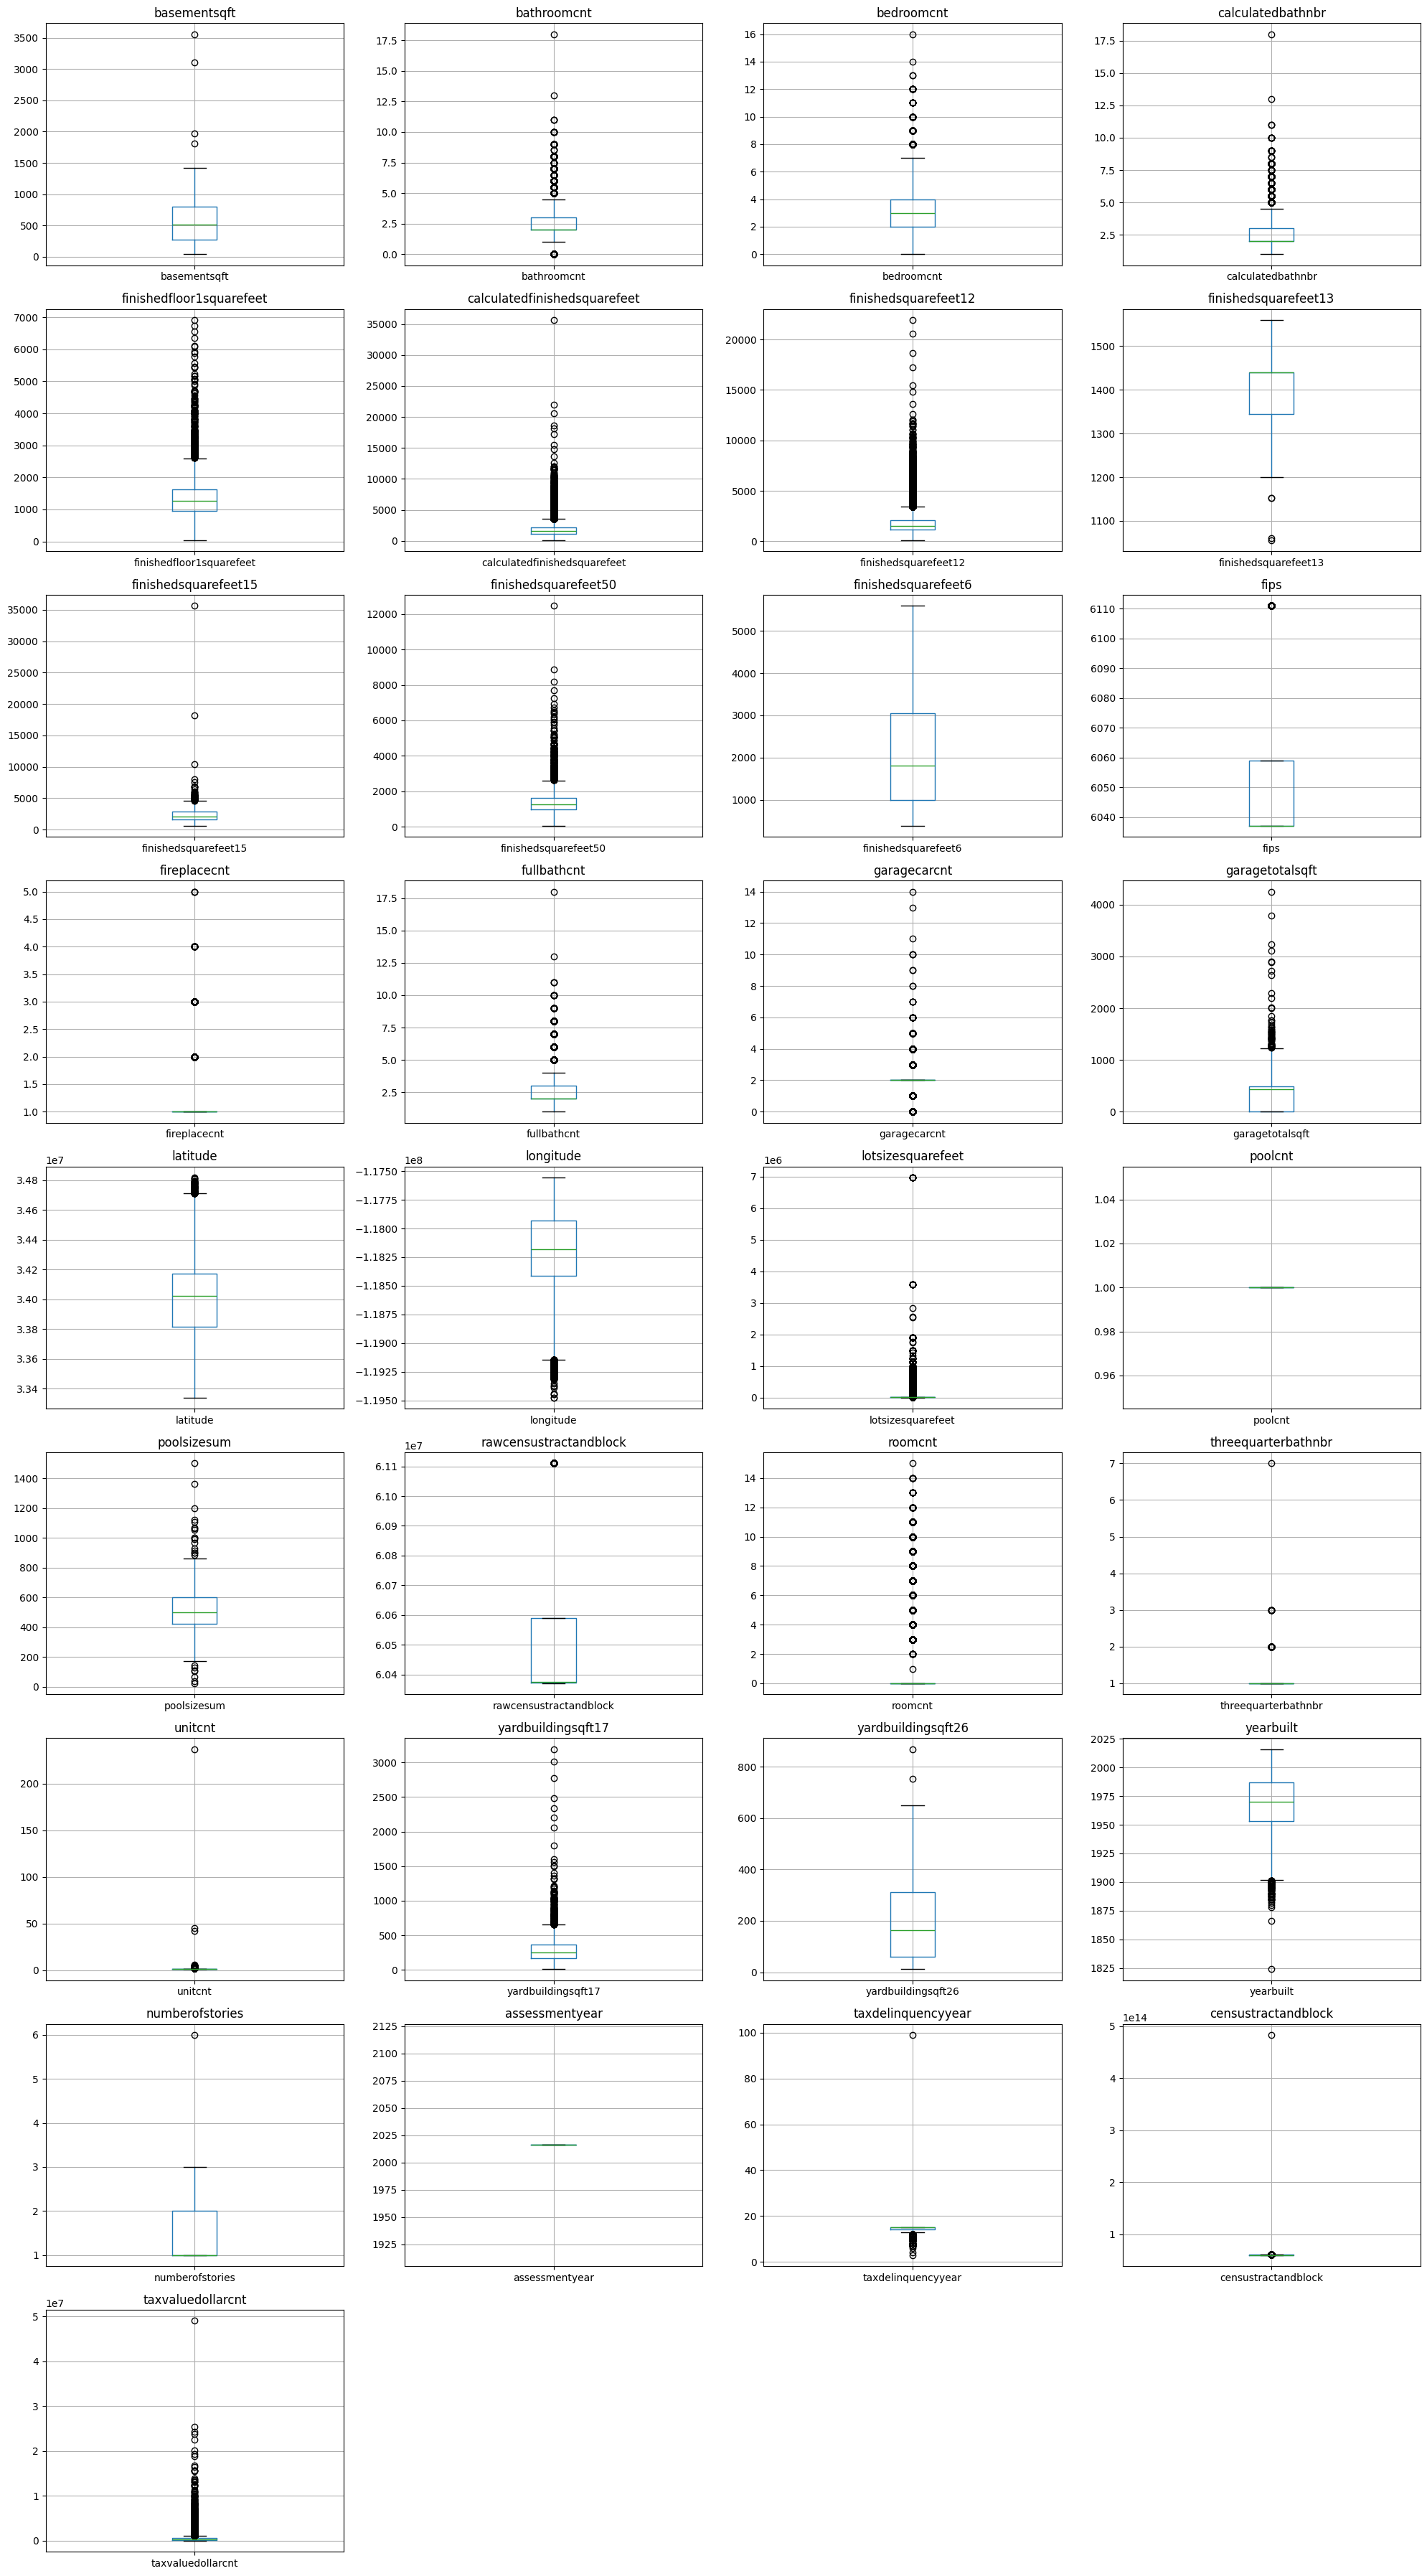

In [12]:
# =======================================================
# Generate Boxplots for each of the Numeric Variables in 
# the dataset for outlier analysis
# =======================================================


numeric_cols = df_numeric.columns

num_vars = len(numeric_cols)
ncols = 4
nrows = -(-num_vars // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df_numeric.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Categorical Variable Pre-Analysis: Bar Charts**

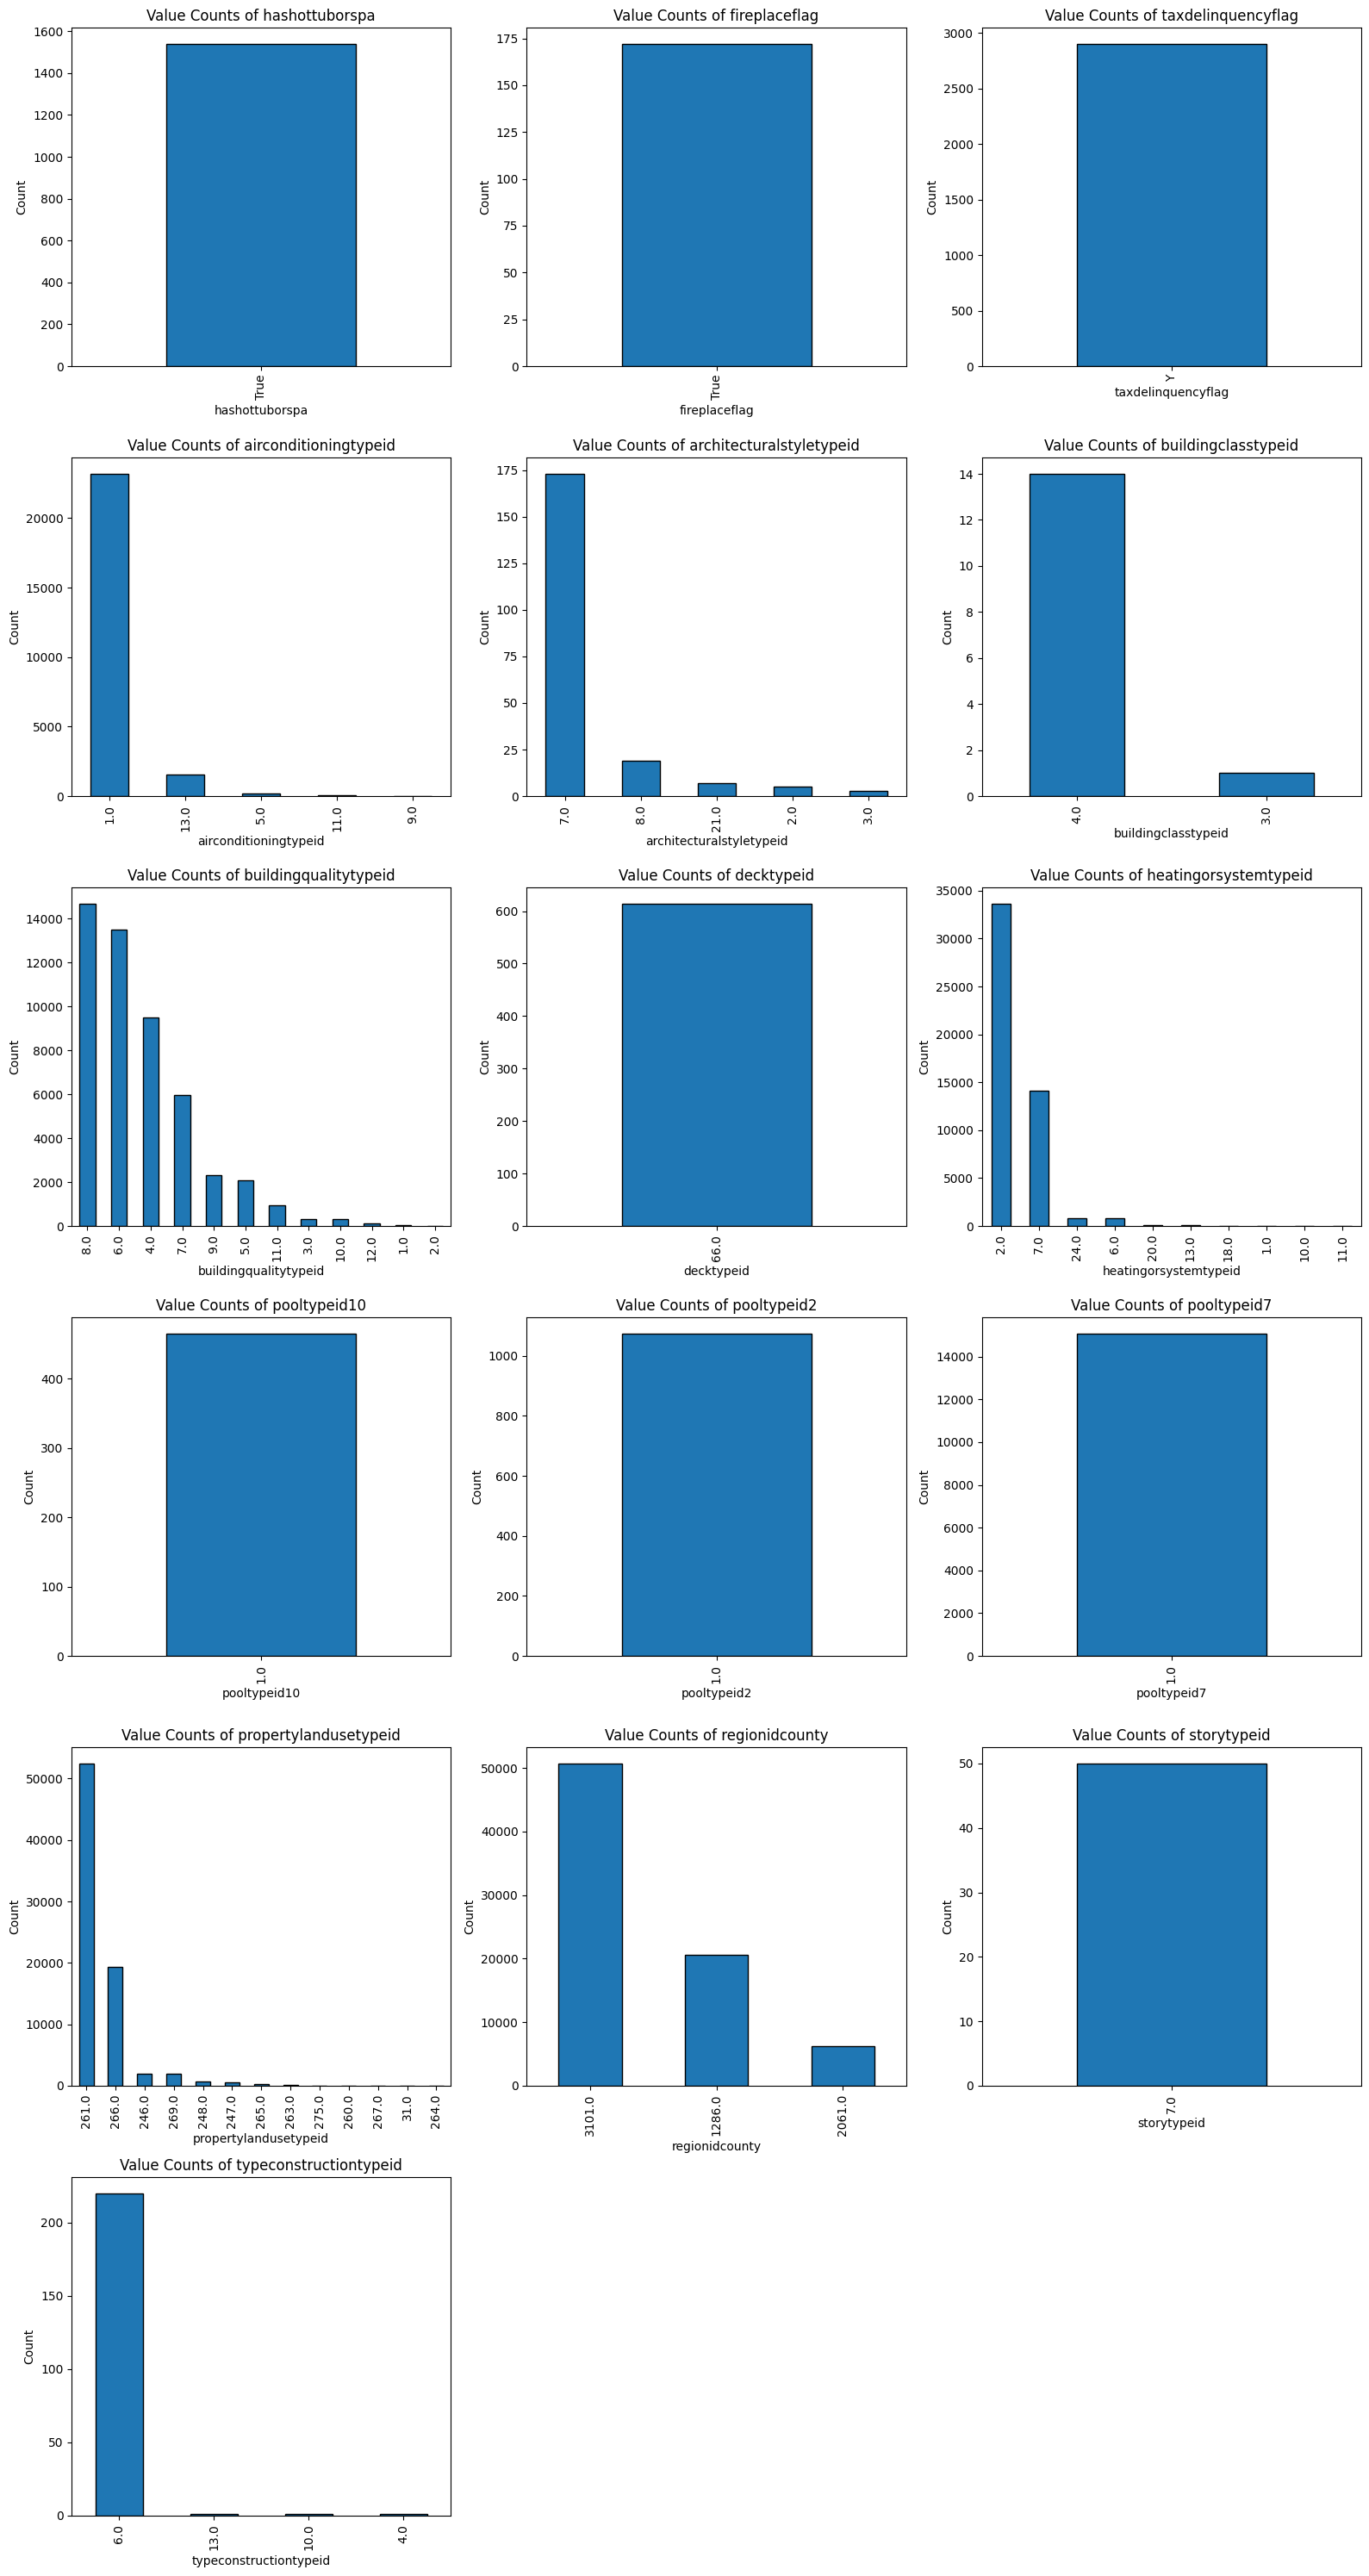

In [13]:

# pre-processing to get rid of fields with extremely high cardinality 
part2plots_categorical_preprocessing = df_categorical.copy()
part2plotscatagorical = part2plots_categorical_preprocessing.drop(columns=(['propertycountylandusecode', 'propertyzoningdesc', 'parcelid', 'regionidcity', 'regionidneighborhood', 'regionidzip']))

#Set columns and rows
num_cols = part2plotscatagorical.shape[1]
cols = 3
rows = (num_cols + cols - 1) // cols  # Ceiling division for number of rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each column and create a bar plot of value counts
for i, col in enumerate(part2plotscatagorical.columns):
    part2plotscatagorical[col].value_counts().plot(kind='bar', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Value Counts of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**2B General Observations**

**2B General Observations**

Looking into the distributions overall, it looks like most of the distributions of numeric varaibles are right-skewed, which makes sense from a housing perspective (while the majority of houses in a given area are distributed around a mean, there can be outlier mansions or mansion neighborhoods where the the house price, square feet measurements, etc. are much higher.)

Additionally, there are several features like censustractandblock and assessment year which have a very strong peak at one value, with very few data points in other values. This suggests that these columns may not be very useful to our analysis, or may benefit from some type of consolidation (in the case of redundancy) / or transformation (in the case of heavily skewed variables). 

- **Living Area Feature Distributions**

    - While finishedsquarefeet12, calculatedfinishedsquarefeet, finishedsquarefeet50, finishedfloor1squarefeet, and finishedsquarefeet15 all show right-skewed distributions with a long tail (indicating the presense of larger properties in the dataset), they exhibit varying degrees of scale, which is indicative that some of these feature variables have limited data. As such these fields were flagged for review for future sections of this analysis. 

    - Additionally, features like finishedsquarefeet13 and finishedsquarefeet6 either have very few values (as indicated by the scale of the histogram) or are very flat, which are indicative of limited data (especially taken the null counts for these were above 99%). Again, both of these were flagged for review for these reasons. 

- **Bedroom and Bathroom Features**

    - Feature variables like bathroomcnt, fullbathcnt, threequarterbathnbr, roomcnt,  and bedroomcnt seem clustered around common values (1-4 for example), with very few extreme outliers. These variables were mostly determined to be very well behaved and are expected to contribute to our analysis. The only one of these that we might have issues with is the field,  threequarterbathnbr,  mostly because it clusters around a single number (1) and has a high degree of null values, (86.98% null). This did seem like it made logical sense as most bathrooms are not 3/4 baths, but nevertheless, it was flagged for further review by the team. 

- **Fireplace, Pool, Garage, and Hot Tub / Spa Features**

    - Fireplace and Pool fields both suffered from a large amount of seeming redundancy  regarding their fields. (fireplace had two different fields indicating the presense of a fireplace, and neither was very well filled out, while poolcount, poolsizesum, and several pooltypeid fields indicated the presense of a pool.) These fields were flagged for review as they seemed like good candidates for field consolidation. 

    - garagecarcnt seemed like it clustered around common values (1-3) and seemed like it was complete in terms of number of records, however, it could probably be consolidated with the field garagetotalsqft for modeling. 


- **Lot and Property Featueres**

    - lotsizesquarefeet and yarbuildingsqft17/26 seem like they could be consolidated into a single field and were thus tagged for further review. (This is mostly due to the lack of datapoints, and the seeeming redundancy between all of the ways to total up the same property area.) Additionally, unitcnt looks like it has a single data spike around the 1 unit range (while this makes sense as the dataset could well be an extract consisting entirely of single famitly homes), this could hinder this particular variable's value in terms of modeling. 

- **Temporal and ID Features**
    - yearbuilt is roughly bell-shaped but shows many homes built between 1950–2000.
    - assessmentyear has only a single value (2016) -- this will offer very little in terms of modeling. 
    - taxdelinquencyyear is sparsely populated and could well be consolidated with taxdelinquencyflag. 
    - rawcensustractandblock, censustractandblock, and parcelid are effectively unique identifiers and not useful for modeling so they are flagged for review as well. 

**- General Observations --  Any problems (e.g., outliers, any odd characteristics)?**

When outlier analysis was completed, most of the feature variables exhibited outliers on the high end of their respective ranges. This behavior mirrors what was observed in the histograms: many of the feature variables are right-skewed. This aligns with expectations—while most houses cluster around a central mean, a few larger houses (with more bedrooms, bathrooms, garage space, square footage, etc.) are significantly more valuable. This is reflected in both the feature variables and the target variable.

It’s also worth noting that this analysis was conducted before the Data Cleaning, Imputing, and Encoding phase. As such, feature variables that displayed concerning characteristics—and were subsequently flagged for review—also show outlier activity. These variables will be addressed during a later stage of the process.

One outlier that stood out was in the ‘yearbuilt’ variable, where one house in the dataset was built in 1825. This is surprising given that most of the states represented in the dataset are in the western U.S. (e.g., California, Oregon, Pacific Islands). However, it’s not entirely unheard of, as settlers were constructing homes in the West during that time period.


**- General Observations -- Anything else interesting?**


A few additional findings stood out to the team. Some variables exhibited strange or unexpected behavior, which became more apparent through visualization:
- FPS, for instance, appears to have only three possible values. This limited variability may reduce its usefulness for further analysis.
- Extreme outliers were detected in taxdeliquencyyear (100) -- if this feature is kept, we will have to address this. 

___

### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:

#### **Visualizations for the Target and 3 Varialbes of Interest**
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

#### **Variable Discussion #1: Target Variable ('taxvaluedollarcnt')**

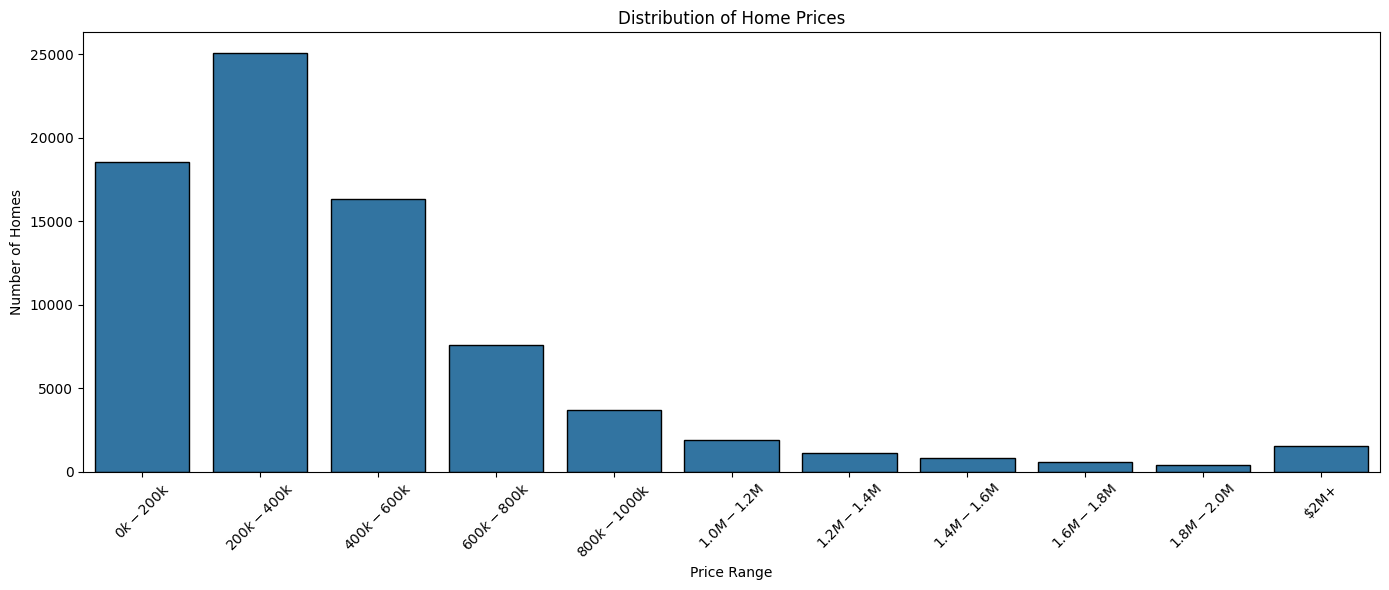

In [14]:
# =======================================================
# Generate a custom histogram including custom bins for the 
# target variable.
# =======================================================



df_part2plots = df_numeric.copy()

# Create bins: 0 to 2M in 200k steps. Then a final bin for >2M. 
bins = list(range(0, 2000001, 200000))  # 0 to 2M in 200k steps
bins.append(float('inf'))  # Final bin for 2M+

# Create labels for bins
labels = []
for i in range(len(bins) - 2):
    low = bins[i]
    high = bins[i + 1]
    if low < 1_000_000:
        label = (f"${low//1000}k - ${high//1000}k")
    else:
        label = (f"${low/1_000_000:.1f}M - ${high/1_000_000:.1f}M")
    labels.append(label)
labels.append("$2M+")  # Final label for the last bin

# Apply binning
df_part2plots['price_range'] = pd.cut(
    df_part2plots['taxvaluedollarcnt'],
    bins=bins,
    labels=labels,
    right=False
)

# Count the number of homes in each bin
price_counts = df_part2plots['price_range'].value_counts().sort_index().reset_index()
price_counts.columns = ['Price Range', 'Count']

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=price_counts, x='Price Range', y='Count', edgecolor='black', log_scale=False)
plt.xticks(rotation=45)
plt.title('Distribution of Home Prices')
plt.xlabel(r'Price Range', usetex=False)
plt.ylabel('Number of Homes')
plt.rcParams["text.usetex"] = False
plt.tight_layout()
plt.show()

**Target Variable Discussion**

The distribution of the target variable, taxvaluedollarcnt, mirrors many of the feature variables in the dataset: it follows a roughly right-skewed distribution with a sharp peak at the lower end and a long tail toward higher values. This reflects real-world housing markets, where the majority of homes fall within a reasonable price range, while a smaller number of high-value properties—such as mansions—exist in areas like California, Oregon, and U.S. Pacific Island territories. 

**Outlier Analysis**

As confirmed by the box plots above, outliers begin to emerge around the $200K–$400K range, with values stretching all the way up to nearly $5 million. To improve interpretability in visualizations, any home valued over $2 million was grouped into a single bin. This includes homes in the $2.2M–$2.4M range as well as those in the $4.8M–$5.0M range. While these outliers exist, they become increasingly rare as the values move further from the peak, which is consistent with a typical right-skewed distribution.

**Anything else that is Interesting**

Scaling the bins appropriately for this variable was a challenge, given the wide range of values and heavy skew. As the analysis progresses, this target variable will be a strong candidate for logarithmic transformation to reduce skewness and improve model performance. Applying such a transformation will help ensure that downstream models interpret and weight this variable more effectively.

___

#### **Variable Discussion #2: Feature Variable ("calculatedfinishedsqft")**

This is our first feature variable of interest -- a feature variable chosen as it mirrors the same behavior of a lot of feature variables in the dataset, as well as the target variable.

<Axes: xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

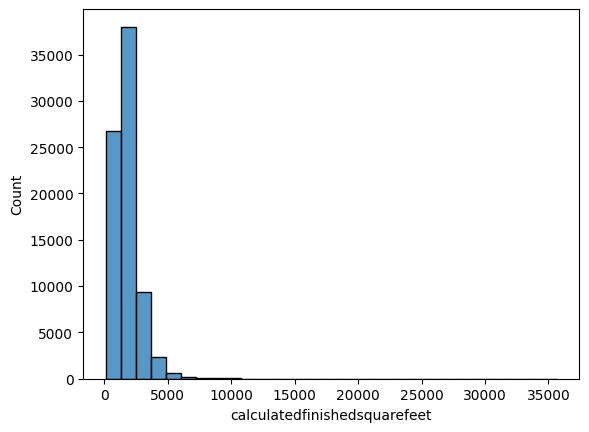

In [15]:
# =========================================================
# Distribution of the Feature Variable with a Normal Scale
# =========================================================


sns.histplot(df_numeric, x='calculatedfinishedsquarefeet', bins=30, log_scale=False)

<Axes: xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

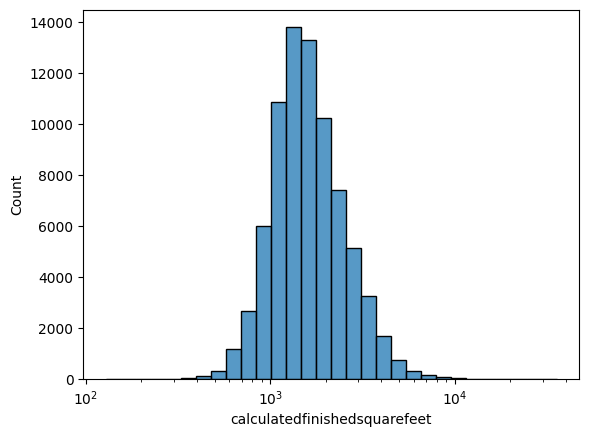

In [16]:
# =========================================================
# Distribution of the Feature Variable with a Log Scale
# =========================================================

sns.histplot(df_numeric, x='calculatedfinishedsquarefeet', bins=30, log_scale=True)

**Feature Variable Discussion "calculatedfinishedsqft"**

**Distribution Discussion**

The distribution of the calculatedfinishedsquarefeet feature appears to be log-normal. It exhibits a strong right skew under normal conditions, but becomes approximately normal when a log transformation is applied. This variable was chosen for closer analysis because it mirrors the distribution of both the target variable and several other feature variables in the dataset. In Part 5 of the analysis, we will need to carefully evaluate whether this and similar variables should be transformed prior to modeling.

**Outlier Discussion**

As expected with a right-skewed distribution, there are a number of high-end outliers in the raw data. This is evident both in the histogram and the corresponding boxplot. Applying a log transformation effectively compresses these extreme values, making them more manageable. However, it also introduces some low-end outliers, though their relative scale compared to the median is much smaller after transformation.

**Interesting Observations**

The most notable observation is that this distribution becomes approximately normally distributed under a log scale. This highlights the importance of scale normalization across the dataset. While some features range from 1–20 and others from 1–5 million, many of them share a similar distribution shape. As we proceed with the analysis, it will be important to account for these differences in scale to ensure model performance and interpretability are not negatively impacted.

___

#### **Variable Discussion #3: Feature ("bedroomcount")**

This is a plot of another variable in the dataset that mirrors the target variable and other variables in terms of initial distrubution shape, but exemplifies a case where a log transformation would not be appropriate. 

<Axes: xlabel='bedroomcnt', ylabel='Count'>

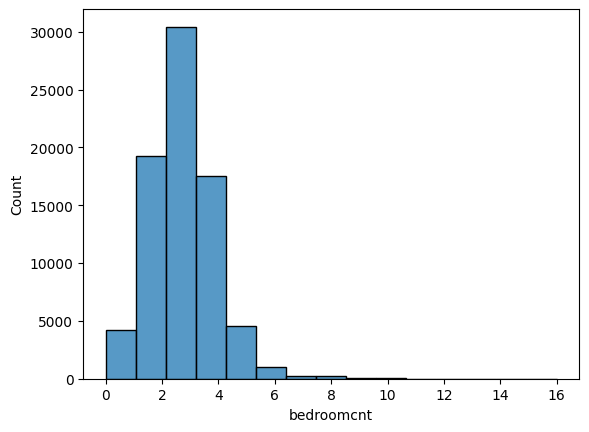

In [17]:
sns.histplot(df_numeric, x='bedroomcnt', bins=15, log_scale=False)

**Feature Variable Discussion "calculatedfinishedsqft"**

**Distribution Discussion**

Although this variable exhibits a heavy right skew with several high-end outliers, a log transformation is not necessary or valuable in this case due to the small scale of the distribution (ranging from 1 to 20). This contrasts with other variables like the target (taxvaluedollarcnt, ranging from 1 to 5 million) or calculatedfinishedsquarefeet (which can reach into the tens of thousands), where scaling transformations are more impactful.

**Outlier Discussion**

As seen in the boxplot above, outliers begin at 7 bedrooms and extend up to 16 bedrooms. There are no outliers on the lower end of the distribution—a trend that appears across many of the feature variables. This makes intuitive sense, as a home cannot have fewer than zero bedrooms.

**Interesting Observations**

This feature was selected because its distribution shape mirrors both the target variable (taxvaluedollarcnt) and the calculatedfinishedsquarefeet variable: all exhibit right skew. However, in this case, the scale of the data is too limited to warrant a log transformation. This highlights the importance of evaluating each feature individually to determine whether transformation is appropriate, which will be a key step in the upcoming phases of our analysis.

___

#### **Variable Discussion #4: Feature ('propertylandusetypeid')**

Though this last one will require some pre-processing, it is important to consider as 'id' enumerated columns make up a significant subsection of our dataset. 

In [18]:
# ==================================================
# Pre-Processing for  PropertyLandUseTypeID to make
# it more interpretable than the enumerated labels
# ==================================================

property_land_use_mapping = {
    31: "Commercial",
    46: "Multi-Story Store",
    47: "Store/Office(mixedUse)",
    246: "Duplex",
    247: "Triplex",
    248: "Quadruplex",
    260: "Residential General",
    261: "Single Family Residential",
    262: "Rural Residence",
    263: "Mobile Home",
    264: "Townhouse",
    265: "Cluster Home",
    266: "Condominium",
    267: "Cooperative",
    268: "Row House",
    269: "Planned Unit Development",
    270: "Residential Common Area",
    271: "Timeshare",
    273: "Bungalow",
    274: "Zero Lot Line",
    275: "Modular/Prefabricated",
    276: "Patio Home",
    279: "Infered Single Family",
    290: "Vacant Land - General",
    291: "Residential Vacant Land"
}

# Create a copy of the df for this plot and remap the 
part2_plot_propertylanduse = df.copy()
part2_plot_propertylanduse['propertylandusetypeid'] = part2_plot_propertylanduse['propertylandusetypeid'].map(property_land_use_mapping)

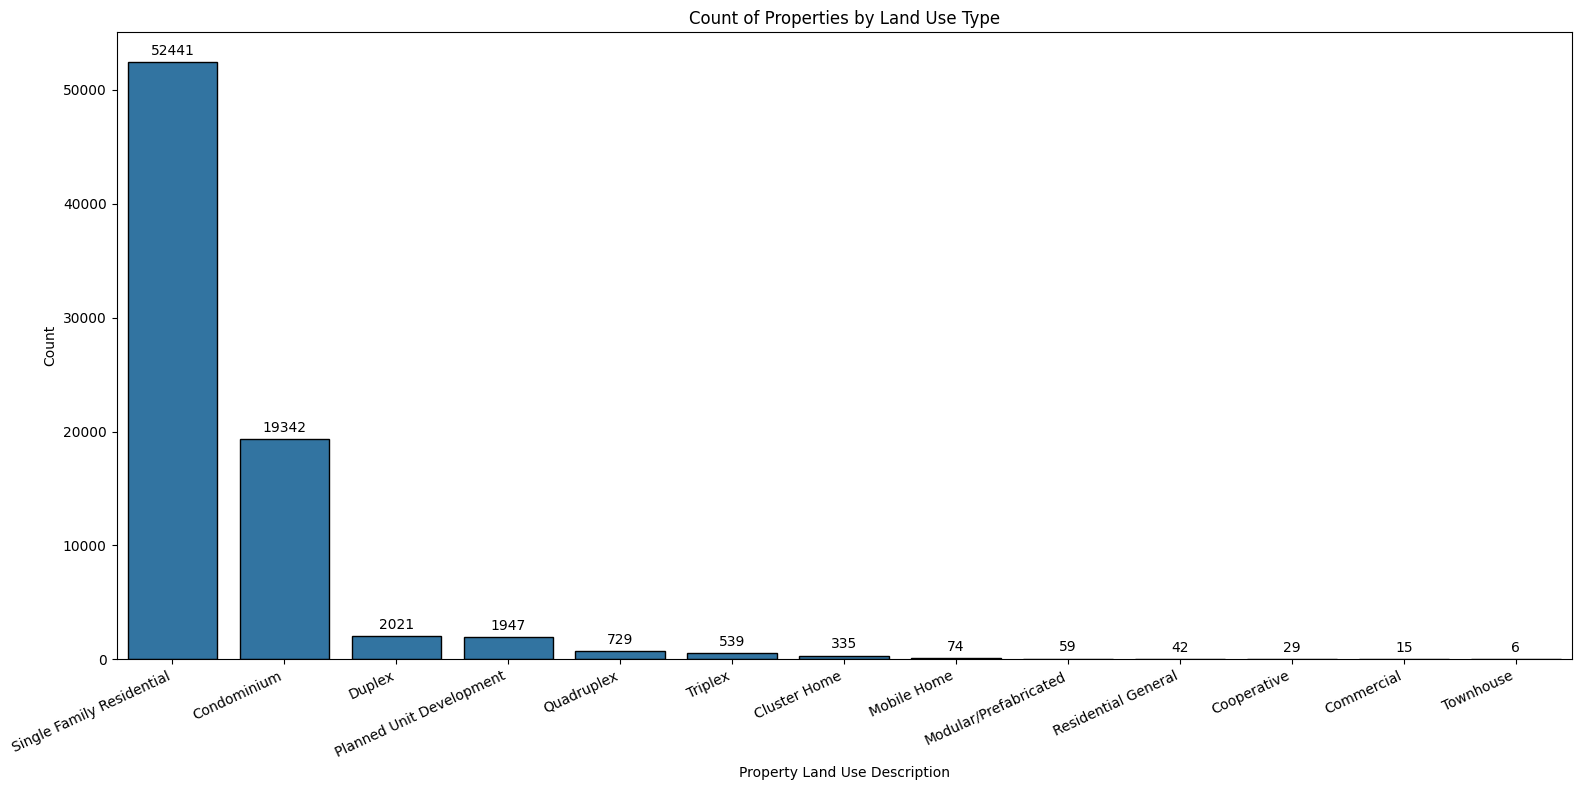

In [19]:
# =====================================================
# Plot PropertyLandUseTypeID as a Categorical Variable
# =====================================================

# Make a barplot with the counts of each category
plt.figure(figsize=(16,8))
ax = sns.countplot(
    data=part2_plot_propertylanduse,
    x='propertylandusetypeid',
    order=part2_plot_propertylanduse['propertylandusetypeid'].value_counts().index,
    edgecolor='black'
)

# Count labels at the top for better visualization
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=10)

# Make labels and rotate them slightly (so they don't overlap)
plt.xticks(rotation=25, ha='right')
plt.title('Count of Properties by Land Use Type')
plt.xlabel('Property Land Use Description')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Feature Variable Discussion "Land Use Type Id"**

**Distribution Discussion**

This variable was chosen to illustrate one of the possible approaches for working with categorical variables once they are mapped using the enumeration key obtained from Zillow. While this feature does not have a “distribution” in the traditional numeric sense, it was important to include in the analysis because ID-type fields make up a significant subset of our dataset’s features.

The majority of records fall under the “Single Family Residential” category, with “Condominium” as the second most common. Despite being the next most frequent, condominiums appear in less than half as many records as single-family homes, highlighting a significant skew toward a single land use category.

**Outlier Discussion**

Since this is a categorical variable, traditional numeric outliers do not apply. However, several categories appear very infrequently and can be considered outlier-like in a categorical sense. Specifically, everything from “Cluster Home” onward comprises less than 1% of the total dataset combined. These rare categories may be consolidated or excluded during modeling, depending on their relevance.

**Interesting Observations**

As mentioned earlier, a substantial number of features in the dataset are enumerated ID fields. This makes it important to explore at least one of them in detail here. While enumeration keys were available for some variables (such as this one), others lacked documentation—despite being part of the same Zillow Kaggle dataset. As a result, although variables like propertylandusetypeid are likely to be carried forward into later stages of the analysis, several other ID-type fields have been flagged for further review due to missing or incomplete metadata.

___

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [20]:
#######################################
# Preparation for Data Cleaning: 
#######################################
# Create a copy of the original DataFrame
df_clean = df.copy()

def drop_features(dataframe, columns_to_drop):
    initial_columns = dataframe.shape[1]
    # Drop each column gradually, using try-except to avoid errors if the column is missing
    for col in columns_to_drop:
        try:
            dataframe = dataframe.drop(columns=[col])
            print(f"Dropped column: {col}")
        except KeyError:
            print(f"Column {col} not found. Skipping.")
    final_columns = dataframe.shape[1]
    print(f"Number of columns to be dropped: {len(columns_to_drop)}")
    print(f"Number of columns before dropping: {initial_columns}")
    print(f"Number of columns after dropping: {final_columns}")
    return dataframe


In [21]:
def remove_outliers_iqr(df, target_col, lower_mult=1.0, upper_mult=1.5):
    # Compute quartiles and IQR
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds; ensure lower_bound is not negative
    lower_bound = max(Q1 - lower_mult * IQR, 0)
    upper_bound = Q3 + upper_mult * IQR

    # Filter out the outliers deterministically
    df_no_outliers = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)].copy()
    
    return df_no_outliers, lower_bound, upper_bound

In [22]:
def create_indicator_from_columns(df, columns, new_column_name):
    # Initialize a boolean series with False for all rows.
    indicator = pd.Series(False, index=df.index)
    
    for col in columns:
        try:
            if col in df.columns:
                indicator = indicator | df[col].notnull()
            else:
                print(f"Warning: Column '{col}' not found. Skipping.")
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    # Assign the indicator as an integer column to the DataFrame
    df[new_column_name] = indicator.astype(int)
    return df

In [ ]:
################################################
# Drop features unsuitable for regression task: 
################################################

columns_to_drop_unsuitable = [
    "assessmentyear",            # Only one value, 2016
    "parcelid",                  # Unique identifier; not useful for ML
    "rawcensustractandblock",    # Unprocessed census tract and block; ~39k unique IDs
    "censustractandblock",       # Processed census tract and block; ~39k unique IDs
    "latitude",                  # Out of scope
    "longitude",                 # Out of scope
    "propertyzoningdesc",        # 1908 unique text codes with unknown meaning
    "regionidneighborhood",      # 480 unique values
    "regionidzip",               # 389 unique values (could be grouped, but not for this milestone)
    "regionidcity",              # 175 unique values (encoding manageable, but not part of this milestone)
    "propertycountylandusecode",  # 75 unknown IDs

]


df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_unsuitable).copy()


Dropped column: assessmentyear
Dropped column: parcelid
Dropped column: rawcensustractandblock
Dropped column: censustractandblock
Dropped column: latitude
Dropped column: longitude
Dropped column: propertyzoningdesc
Dropped column: regionidneighborhood
Dropped column: regionidzip
Dropped column: regionidcity
Dropped column: propertycountylandusecode
Dropped column: yearbuilt
Number of columns to be dropped: 12
Number of columns before dropping: 55
Number of columns after dropping: 43


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [ ]:
################################################
# Drop features with too many missing values: 
################################################

# threshold 90% of missing values: 

columns_to_drop_too_many_missing_90 = [
    "buildingclasstypeid",             #      77598      99.98    Numeric
    "finishedsquarefeet6",             #      77227       99.5    Numeric
    "finishedsquarefeet13",            #      77571      99.95    Numeric
    "finishedsquarefeet15",            #      74586       96.1    Numeric
    "finishedsquarefeet50",            #      71576      92.22    Numeric
    "basementsqft",                    #      77563      99.94    Numeric
    "storytypeid",                     #      77563      99.94    Numeric
    "architecturalstyletypeid",        #      77406      99.73    Numeric
    "typeconstructiontypeid",          #      77390      99.71    Numeric
    "decktypeid",                      #      76999      99.21    Numeric
    "poolsizesum",                     #      76744      98.88    Numeric
    "taxdelinquencyflag",              #      74713      96.26 Categorical
    "taxdelinquencyyear",              #      74713      96.26    Numeric
    "finishedfloor1squarefeet"         #      71576      92.22    Numeric
]

df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_too_many_missing_90).copy()

# threshold 60% of missing values and values are not useful for regression task:
columns_to_drop_too_many_missing_60 = [
    "threequarterbathnbr",             #      67507      86.98    Numeric
    "pooltypeid7",                     #      62534      80.57    Numeric
    "poolcnt",                         #      61439      79.16    Numeric
    "numberofstories",                 #      60014      77.32    Numeric
    "airconditioningtypeid",           #      52606      67.78    Numeric
    "garagecarcnt",                    #      52093      67.12    Numeric
    "garagetotalsqft",                 #      52093      67.12    Numeric
    "regionidneighborhood"             #      46639      60.09    Numeric
]

df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_too_many_missing_60).copy()

# To be dropped later:
columns_to_be_dropped_later = [
    'fireplacecnt', 
    'fireplaceflag',
    'yardbuildingsqft26',
    'pooltypeid10',
    'pooltypeid2',
    'poolcnt',
    'hashottuborspa',
    'pooltypeid10',
    'poolcnt',
    'poolsizesum',
    'pooltypeid2',
    'pooltypeid7'
]

print(f"\nColumns to be used in new features and to be dropped later: {columns_to_be_dropped_later}")

Column buildingclasstypeid not found. Skipping.
Column finishedsquarefeet6 not found. Skipping.
Column finishedsquarefeet13 not found. Skipping.
Column finishedsquarefeet15 not found. Skipping.
Column finishedsquarefeet50 not found. Skipping.
Column basementsqft not found. Skipping.
Column storytypeid not found. Skipping.
Column architecturalstyletypeid not found. Skipping.
Column typeconstructiontypeid not found. Skipping.
Column pooltypeid10 not found. Skipping.
Column decktypeid not found. Skipping.
Column poolsizesum not found. Skipping.
Column pooltypeid2 not found. Skipping.
Column hashottuborspa not found. Skipping.
Column taxdelinquencyflag not found. Skipping.
Column taxdelinquencyyear not found. Skipping.
Column finishedfloor1squarefeet not found. Skipping.
Number of columns to be dropped: 17
Number of columns before dropping: 18
Number of columns after dropping: 18
Column threequarterbathnbr not found. Skipping.
Column pooltypeid7 not found. Skipping.
Column poolcnt not foun

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



- If a feature is missing 90% or more of its data, it is generally considered too unreliable to contribute meaningfully to the analysis.

- If a feature has more than 60% missing data, we need to examine whether the available values are highly informative or critical to the model; in such cases, we might opt to impute the missing data instead of dropping the feature.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [25]:
# Parameters
target_col = 'taxvaluedollarcnt'
null_threshold = 0.6
print(f"Null threshold: {null_threshold*100}%")

# Step 1: Drop samples with null values in the target column
print(f"Number of samples before dropping null values in the target: {df_clean.shape[0]:,.0f}")
df_clean = df_clean.dropna(subset=[target_col]).copy()
print(f"Number of samples after dropping null values in the target: {df_clean.shape[0]:,.0f}")


# Step 2: Drop samples with too many null values
print(f"Number of samples before dropping too many null values in the target: {df_clean.shape[0]:,.0f}")
df_clean = df_clean[df_clean.isnull().mean(axis=1) <= null_threshold].copy()
print(f"Number of samples before dropping too many null values in the target: {df_clean.shape[0]:,.0f}")


Null threshold: 60.0%
Number of samples before dropping null values in the target: 77,613
Number of samples after dropping null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,496


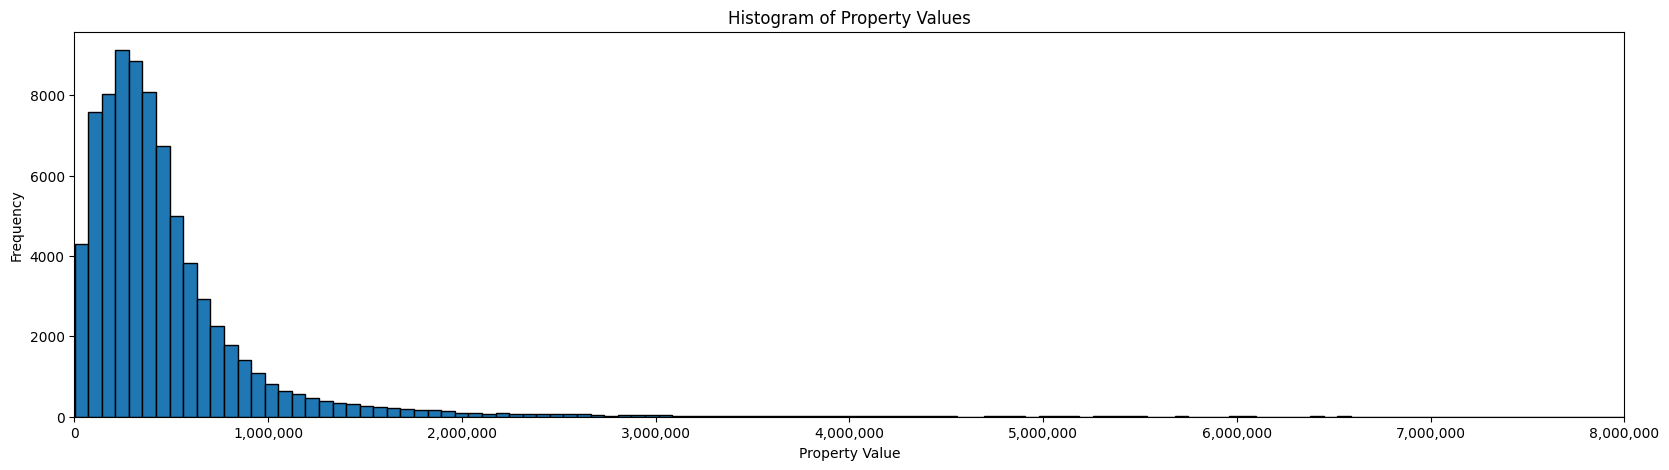

Minimum value of target: 1,000
Maximum value of target: 49,061,236


In [26]:
ax = df_clean[target_col].plot.hist(figsize=(20,5), bins=700, edgecolor='black')

# Use StrMethodFormatter to format the x-axis labels with commas
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlim([0, 8_000_000])

plt.title("Histogram of Property Values")
plt.xlabel("Property Value")
plt.ylabel("Frequency")

plt.show()
min_val = df_clean[target_col].min()
max_val = df_clean[target_col].max()

print(f"Minimum value of target: {min_val:,.0f}")
print(f"Maximum value of target: {max_val:,.0f}")

This histogram shows a strong **right-skew** in property values, with the bulk of properties falling below 1 million and a **long tail stretching toward 8 million (chart limit)**. 

A clear peak appears in the lower-value range (roughly under 500k), after which the frequency gradually declines. The relatively small but notable number of properties in the high-value range contributes to the long tail on the right. 

This distribution is typical of real estate data, where a majority of properties cluster at lower-to-moderate prices, and a smaller number are significantly more expensive.

In [27]:
df_original = df_clean.copy()

df_clean_deleted_outliers, lower_bound, upper_bound = remove_outliers_iqr(df_original, target_col, lower_mult=0.5, upper_mult=1.5)

print(f"Rows before outlier removal: {df_original.shape[0]:,.0f}")
print(f"Rows after outlier removal: {df_clean_deleted_outliers.shape[0]:,.0f}")
print(f"Rows deleted: {df_original.shape[0]-df_clean_deleted_outliers.shape[0]:,.0f}")
print(f"Lower bound: {lower_bound:,.0f}")
print(f"Upper bound: {upper_bound:,.0f}")


Rows before outlier removal: 77,496
Rows after outlier removal: 72,149
Rows deleted: 5,347
Lower bound: 25,980
Upper bound: 1,112,077


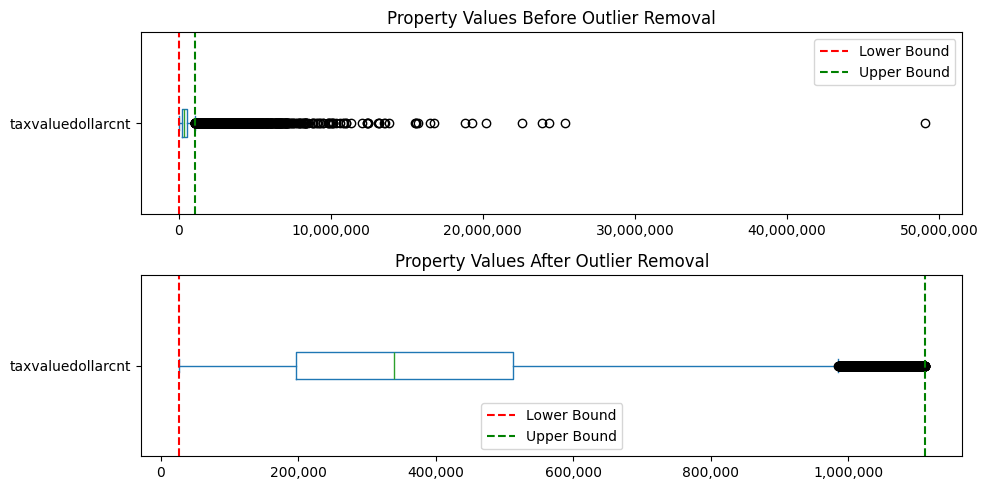

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Original data box plot with limits
df_original[target_col].plot(kind='box', vert=False, ax=axes[0])
axes[0].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
axes[0].axvline(x=upper_bound, color='g', linestyle='--', label='Upper Bound')
axes[0].legend()
axes[0].set_title("Property Values Before Outlier Removal")
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Data after outlier removal with same limit lines (for reference)
df_clean_deleted_outliers[target_col].plot(kind='box', vert=False, ax=axes[1])
axes[1].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
axes[1].axvline(x=upper_bound, color='g', linestyle='--', label='Upper Bound')
axes[1].legend()
axes[1].set_title("Property Values After Outlier Removal")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

As a result of outlier deletion, the box plot now shows a more compact range (topping out around the calculated upper bound) and reveals the distribution of the majority of properties more clearly. 
While the data remain right-skewed, the extreme outliers no longer obscure the main concentration of values in the lower and mid ranges.

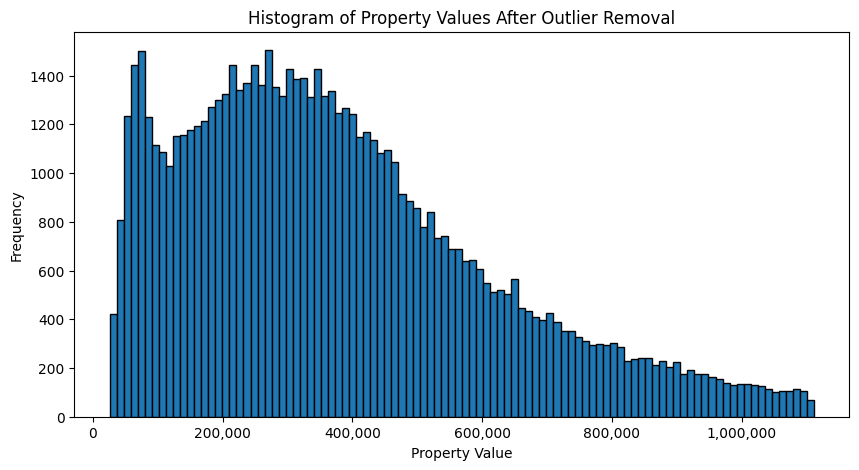

Minimum value of target: 26,038
Maximum value of target: 1,111,730


In [29]:
ax = df_clean_deleted_outliers[target_col].plot.hist(figsize=(10,5), bins=100, edgecolor='black')

# Use StrMethodFormatter to format the x-axis labels with commas
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Histogram of Property Values After Outlier Removal")
plt.xlabel("Property Value")
plt.ylabel("Frequency")
plt.show()
min_val = df_clean_deleted_outliers[target_col].min()
max_val = df_clean_deleted_outliers[target_col].max()

print(f"Minimum value of target: {min_val:,.0f}")
print(f"Maximum value of target: {max_val:,.0f}")

The histogram is strongly right-skewed, with most properties in the 100k–400k range, peaking around 150–250k, and then gradually tapering off. 

After removing extreme outliers, the distribution extends to about 1 million, with fewer properties in the higher ranges. Overall, it remains **unimodal**, with a main peak in the lower-to-mid range and a tail toward higher prices.

We are planning to use tree-based models like **Random Forests**, which typically **handle skewed target distributions well** without requiring additional transformation. 

However, if we later decide to experiment with other modeling techniques that are more sensitive to target distribution, we may revisit and apply target transformation at that stage.


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


- Samples with excessive nulls:
  - We drop samples that have more than 60% missing values because such rows likely lack sufficient information to contribute meaningfully to the analysis or model training.

- Samples with missing target:
  - Any sample missing the target value is removed, as it cannot be used in supervised learning tasks where the target is required for training.

- Target outliers:
  - We removed samples that are outliers in the target variable (using the IQR method) because these extreme values might be due to data errors or represent atypical cases that could skew the model.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [30]:
def impute_columns(df, columns, method='mean', constant_value=None):
    """
    Impute missing values in specified columns of a DataFrame using a chosen method.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to impute.
        method (str): Imputation method. Options are:
            - 'drop'     : Drop rows with missing values in the specified column(s).
            - 'mean'     : Fill missing values with the mean (numeric columns only).
            - 'median'   : Fill missing values with the median (numeric columns only).
            - 'mode'     : Fill missing values with the mode (most frequent value).
            - 'constant' : Fill missing values with a provided constant value (requires constant_value).
            - 'unknown'  : Fill missing values with the string "Unknown" (typically for categorical features).
        constant_value: The constant value to use when method is 'constant'.
        
    Returns:
        pd.DataFrame: A new DataFrame with the specified columns imputed.
    """
    df_imputed = df.copy()
    
    for col in columns:
        try:
            if col not in df_imputed.columns:
                print(f"Column '{col}' not found in DataFrame. Skipping.")
                continue
            
            if method == 'drop':
                # Drop rows with missing values for this column.
                df_imputed = df_imputed.dropna(subset=[col])
                print(f"Dropped missing values in column '{col}'.")
            
            elif method == 'mean':
                if pd.api.types.is_numeric_dtype(df_imputed[col]):
                    mean_val = df_imputed[col].mean()
                    df_imputed[col] = df_imputed[col].fillna(mean_val)
                    print(f"Filled missing values in column '{col}' with mean: {mean_val:,.2f}")
                else:
                    print(f"Column '{col}' is not numeric. Cannot apply mean imputation. Skipping.")
            
            elif method == 'median':
                if pd.api.types.is_numeric_dtype(df_imputed[col]):
                    median_val = df_imputed[col].median()
                    df_imputed[col] = df_imputed[col].fillna(median_val)
                    print(f"Filled missing values in column '{col}' with median: {median_val:,.2f}")
                else:
                    print(f"Column '{col}' is not numeric. Cannot apply median imputation. Skipping.")
            
            elif method == 'mode':
                mode_series = df_imputed[col].mode()
                if not mode_series.empty:
                    mode_val = mode_series.iloc[0]
                    df_imputed[col] = df_imputed[col].fillna(mode_val)
                    print(f"Filled missing values in column '{col}' with mode: {mode_val}")
                else:
                    print(f"Could not compute mode for column '{col}'. Skipping.")
            
            elif method == 'constant':
                if constant_value is None:
                    print(f"Constant value not provided for constant imputation on column '{col}'. Skipping.")
                else:
                    df_imputed[col] = df_imputed[col].fillna(constant_value)
                    print(f"Filled missing values in column '{col}' with constant value: {constant_value}")
            
            elif method == 'unknown':
                df_imputed[col] = df_imputed[col].fillna('Unknown')
                print(f"Filled missing values in column '{col}' with 'Unknown'.")
            
            else:
                print(f"Imputation method '{method}' is not supported for column '{col}'. Skipping.")
        
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    return df_imputed

# Example usage:
# df_imputed = impute_columns(df, ['column1', 'column2'], method='median')
# df_imputed = impute_columns(df, ['cat_column'], method='unknown')


In [31]:
df_clean = df_clean_deleted_outliers.copy()
# Check  missing values in remaining columns
missing_data = df_clean.isnull().sum()

missing_data[missing_data > 0].index.tolist()
# Impute missing values in numeric columns with mean
df_clean = impute_columns(df_clean, df_clean.select_dtypes(include=['number']).columns.tolist(), method='mean').copy()



Filled missing values in column 'bathroomcnt' with mean: 2.20
Filled missing values in column 'bedroomcnt' with mean: 3.00
Filled missing values in column 'buildingqualitytypeid' with mean: 6.41
Filled missing values in column 'calculatedbathnbr' with mean: 2.21
Filled missing values in column 'calculatedfinishedsquarefeet' with mean: 1,663.15
Filled missing values in column 'finishedsquarefeet12' with mean: 1,634.83
Filled missing values in column 'fips' with mean: 6,048.94
Filled missing values in column 'fireplacecnt' with mean: 1.14
Filled missing values in column 'fullbathcnt' with mean: 2.15
Filled missing values in column 'heatingorsystemtypeid' with mean: 4.01
Filled missing values in column 'lotsizesquarefeet' with mean: 30,548.58
Filled missing values in column 'propertylandusetypeid' with mean: 261.89
Filled missing values in column 'regionidcounty' with mean: 2,536.68
Filled missing values in column 'roomcnt' with mean: 1.50
Filled missing values in column 'unitcnt' with me

In [32]:

print(type(df_clean))

<class 'pandas.core.frame.DataFrame'>


In [33]:
#######################################
# Impute missing values
#######################################

df_clean = df_clean_deleted_outliers.copy()

impute_columns_median = ['column1', 'column2']



df_imputed = impute_columns(df_clean, ['column1', 'column2'], method='median').copy()

Column 'column1' not found in DataFrame. Skipping.
Column 'column2' not found in DataFrame. Skipping.


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [34]:
#######################################
# Encode categorical features
#######################################

print(type(df_clean))




<class 'pandas.core.frame.DataFrame'>


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [35]:
def create_indicator_from_columns(df, columns, new_column_name):
    # Initialize a boolean series with False for all rows.
    indicator = pd.Series(False, index=df.index)
    
    for col in columns:
        try:
            if col in df.columns:
                indicator = indicator | df[col].notnull()
            else:
                print(f"Warning: Column '{col}' not found. Skipping.")
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    # Assign the indicator as an integer column to the DataFrame
    df[new_column_name] = indicator.astype(int)
    return df

In [36]:
#########################################################
# Create some new features
#########################################################

# Compute property age using 2016 as the assessment year
df_clean['propertyage'] = 2016 - df_clean['yearbuilt']

# Group yearbuilt by decade (e.g., 1900s, 1910s, etc.)
df_clean['yearbuilt_decade'] = (df_clean['yearbuilt'] // 10) * 10

#Create new fireplaceflag based on two other columns  fireplacecnt and fireplaceflag
columns = ['fireplacecnt', 'fireplaceflag']
new_column_name = 'fireplaceflag_new'
df_clean = create_indicator_from_columns(df_clean, columns, new_column_name).copy()


# Storage shed/building in yard
columns = ['yardbuildingsqft26','pooltypeid10','pooltypeid2','poolcnt']
new_column_name = 'storageshed_flag'
df_clean = create_indicator_from_columns(df_clean, columns, new_column_name).copy()



columns = ['hashottuborspa','pooltypeid10']
new_column_name = 'hashottuborspa_falg'
df_clean = create_indicator_from_columns(df_clean, columns, new_column_name).copy()




columns = ['poolcnt','poolsizesum','pooltypeid2','pooltypeid7']
new_column_name = 'haspool_falg'
df_clean = create_indicator_from_columns(df_clean, columns, new_column_name).copy()
df_clean[['propertyage','yearbuilt_decade','yearbuilt','fireplaceflag_new', 'fireplacecnt', 'fireplaceflag','storageshed_flag','hashottuborspa_falg']].head(10)

KeyError: 'yearbuilt'

In [ ]:
################################################
# Drop redundant or duplicated features that are used in the new ones
################################################
columns_to_drop_created_as_new_features = [
    "yearbuilt", 
    'fireplacecnt', 
    'fireplaceflag',
    'yardbuildingsqft26',
    'pooltypeid10',
    'pooltypeid2',
    'poolcnt',
    'hashottuborspa',
    'pooltypeid10',
    'poolcnt',
    'poolsizesum',
    'pooltypeid2',
    'pooltypeid7'
    
]

df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_created_as_new_features).copy()

AttributeError: 'function' object has no attribute 'shape'

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **References**  
1. 

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

